In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import models
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import v2
from torchmetrics.classification import MulticlassAccuracy
import numpy as np
from torch.utils.data import default_collate
import datetime
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
no_epochs = 50
learning_rate = 0.0001
batch_size = 128
num_classes = 102

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

SEED = 42
np.random.seed(SEED)
gen = torch.manual_seed(SEED)

acc_function = MulticlassAccuracy(num_classes=num_classes, average='micro').to(device)
loss_fn = nn.CrossEntropyLoss().to(device)


cuda:0


In [3]:
# Data Augmentation
train_transforms = v2.Compose([
    v2.RandomRotation(30),
    v2.RandomResizedCrop(224),
    v2.RandomHorizontalFlip(),
    v2.ToImage(), 
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Assuming you want to keep the default transformations for testing/validation:
default_transforms = v2.Compose([
    models.VGG16_BN_Weights.IMAGENET1K_V1.transforms()
])

flowers_train = datasets.Flowers102(root='./data', split='train', download=True, transform=train_transforms)
flowers_test = datasets.Flowers102(root='./data', split='test', download=True, transform=default_transforms)
flowers_val = datasets.Flowers102(root='./data', split='val', download=True, transform=default_transforms)


In [4]:
cutmix = v2.CutMix(num_classes=num_classes)
mixup = v2.MixUp(num_classes=num_classes)
cutmix_or_mixup = v2.RandomChoice([cutmix, mixup])

def collate_fn(batch):
    return cutmix_or_mixup(*default_collate(batch))

In [5]:
def get_data_loader(batch_size):
    train_loader_MIXED = torch.utils.data.DataLoader(flowers_train, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, generator=gen)
    train_loader = torch.utils.data.DataLoader(flowers_train, batch_size=batch_size, shuffle=True, generator=gen)
    test_loader = torch.utils.data.DataLoader(flowers_test, batch_size=batch_size, shuffle=True, generator=gen)
    val_loader = torch.utils.data.DataLoader(flowers_val, batch_size=batch_size, shuffle=True, generator=gen)
    return train_loader, test_loader, val_loader, train_loader_MIXED

In [6]:
# Early stopping based on accuracy
class AccuracyEarlyStopper:
    def __init__(self, patience=5, min_delta=0.01):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.max_validation_accuracy = 0

    def early_stop(self, validation_accuracy):
        if validation_accuracy > (self.max_validation_accuracy + self.min_delta):
            self.max_validation_accuracy = validation_accuracy
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [7]:
def train(model, optimizer, dataloader, loss_fn=loss_fn):
    running_loss_value = 0
    for images, labels in dataloader:
        optimizer.zero_grad()
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        running_loss_value += loss.item()
        loss.backward()
        optimizer.step()
    return running_loss_value / len(dataloader)

def test_eval(model, dataloader, loss_fn=loss_fn):
    running_loss_value = 0
    running_acc_value = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            acc = acc_function(outputs, labels)
            running_loss_value += loss.item()
            running_acc_value += acc.item()
    running_acc_value /= len(dataloader)
    running_loss_value /= len(dataloader)
    return running_acc_value*100, running_loss_value

def train_eval_test(model, train_dataloader, val_dataloader, test_dataloader, no_epochs=10):
    es = AccuracyEarlyStopper()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    train_loss_arr, train_acc_arr, eval_loss_arr, eval_acc_arr = [], [], [], []
    for i in range(no_epochs):
        start = datetime.datetime.now()
        train_loss = train(model, optimizer, train_dataloader)
        end = datetime.datetime.now()
        time_taken = (end-start).total_seconds()
        eval_acc, eval_loss = test_eval(model, val_dataloader)
        print(f'Epoch {i+1} Train Loss: {train_loss:>8f}, Eval Accuracy: {eval_acc:>0.2f}%, Eval Loss: {eval_loss:>8f}, Time Taken: {time_taken:>4f}s')
        train_loss_arr.append(train_loss)
        eval_loss_arr.append(eval_loss)
        eval_acc_arr.append(eval_acc)
        if es.early_stop(eval_acc):
            print('Early stopping activated')
            break
    test_acc, test_loss = test_eval(model, test_dataloader)
    print(f"Test Accuracy: {test_acc}, Test Loss: {test_loss}")
    return train_loss_arr, train_acc_arr, eval_loss_arr, eval_acc_arr, test_acc, test_loss, time_taken

In [8]:
train_data_loader, test_data_loader, val_data_loader, train_data_loader_mixed = get_data_loader(batch_size)

In [9]:
def create_model():
    model = models.resnet34(weights=models.ResNet34_Weights.DEFAULT)
    model.fc = nn.Linear(512, 102)
    model = model.to(device=device)
    return model

model = create_model()

In [10]:
model_runs = 10

In [11]:
normal_eval_acc_arr, normal_test_acc_arr, normal_time_arr = [], [], []
mixed_eval_acc_arr, mixed_test_acc_arr, mixed_time_arr = [], [], []

for i in range(model_runs):
    normal_model = create_model()
    train_loss_arr, train_acc_arr, eval_loss_arr, eval_acc_arr, test_acc, test_loss, time_taken = train_eval_test(
        normal_model, 
        train_data_loader, 
        val_data_loader, 
        test_data_loader, 
        no_epochs=no_epochs
    )
    
    normal_eval_acc_arr.append(np.mean(eval_acc_arr))
    normal_test_acc_arr.append(test_acc)
    normal_time_arr.append(np.mean(time_taken))
    
    mixed_model = create_model()
    train_loss_arr_mixed, train_acc_arr_mixed, eval_loss_arr_mixed, eval_acc_arr_mixed, test_acc_mixed, test_loss_mixed, time_taken_mixed = train_eval_test(
        mixed_model, 
        train_data_loader_mixed, 
        val_data_loader, 
        test_data_loader, 
        no_epochs=no_epochs
    )
    
    mixed_eval_acc_arr.append(np.mean(eval_acc_arr_mixed))
    mixed_test_acc_arr.append(test_acc_mixed)
    mixed_time_arr.append(np.mean(time_taken_mixed))

Epoch 1 Train Loss: 4.515797, Eval Accuracy: 20.88%, Eval Loss: 3.916007, Time Taken: 7.804727s
Epoch 2 Train Loss: 3.542258, Eval Accuracy: 48.72%, Eval Loss: 3.140982, Time Taken: 7.041564s
Epoch 3 Train Loss: 2.818875, Eval Accuracy: 64.61%, Eval Loss: 2.536935, Time Taken: 7.122076s
Test Accuracy: 60.37946428571429, Test Loss: 2.693140307251288
Epoch 1 Train Loss: 4.702054, Eval Accuracy: 9.71%, Eval Loss: 4.178813, Time Taken: 7.674221s
Epoch 2 Train Loss: 4.298524, Eval Accuracy: 36.10%, Eval Loss: 3.558689, Time Taken: 7.732733s
Epoch 3 Train Loss: 3.556702, Eval Accuracy: 55.31%, Eval Loss: 2.953752, Time Taken: 7.504154s
Test Accuracy: 51.18303572644993, Test Loss: 3.0887420664028244
Epoch 1 Train Loss: 4.562676, Eval Accuracy: 16.37%, Eval Loss: 3.978856, Time Taken: 7.042799s
Epoch 2 Train Loss: 3.542497, Eval Accuracy: 45.88%, Eval Loss: 3.176631, Time Taken: 7.090418s
Epoch 3 Train Loss: 2.838393, Eval Accuracy: 64.79%, Eval Loss: 2.577404, Time Taken: 7.116128s
Test Accur

In [18]:
eval_acc = [np.mean(normal_eval_acc_arr), np.mean(mixed_eval_acc_arr)]
time_taken = [np.mean(normal_time_arr), np.mean(mixed_time_arr)]
test_acc = [np.mean(normal_test_acc_arr), np.mean(mixed_test_acc_arr)]
names = ['normal', 'modified']
colours = ['tab:red', 'tab:blue']

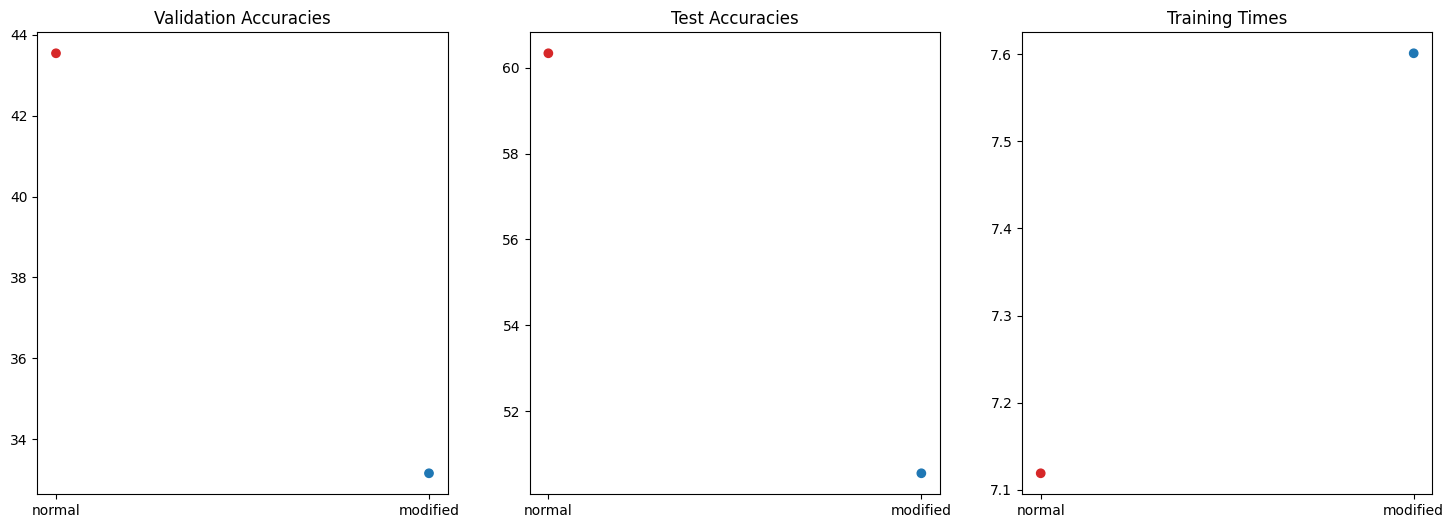

In [19]:
plt.figure(figsize=(18, 6))
plt.subplot(131)
plt.title('Validation Accuracies')
plt.scatter(names, eval_acc, color=colours)
plt.subplot(132)
plt.title('Test Accuracies')
plt.scatter(names, test_acc, color=colours)
plt.subplot(133)
plt.title('Training Times')
plt.scatter(names, time_taken, color=colours)
plt.show()